# Hybrid CNN+GCN (Frozen ResNet50 Backbone)
Model: ResNet50 (pretrained, dibekukan) → GCN head (2-layer) di grid feature map → classifier.
Gunakan untuk dataset kecil (±500 gambar/kelas).

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
# 1) Imports, device, seed
import os, random, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
# 2) Config
DATA_DIR = "dataset"  # GANTI
USE_EXISTING_SPLIT = True
SINGLE_DIR = "/path/to/single/folder"
OUTPUT_SPLIT_DIR = "/path/to/output/split"
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.7, 0.15, 0.15
IMG_SIZE = 224; BATCH_SIZE = 16; NUM_WORKERS = 2
EPOCHS = 20; PATIENCE = 5
LR = 1e-3; WEIGHT_DECAY = 1e-4
GCN_HIDDEN = 256; GCN_DROPOUT = 0.1; GRID_RADIUS = 1

In [4]:
# 3) Optional autosplit
from shutil import copy2
from pathlib import Path
def autosplit_from_single_dir(single_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    single_dir, output_dir = Path(single_dir), Path(output_dir)
    if not output_dir.exists(): output_dir.mkdir(parents=True, exist_ok=True)
    classes = sorted([d.name for d in single_dir.iterdir() if d.is_dir()])
    for split in ["train","val","test"]:
        for cls in classes: (output_dir/split/cls).mkdir(parents=True, exist_ok=True)
    for cls in classes:
        imgs = sorted([p for p in (single_dir/cls).iterdir() if p.is_file()])
        n=len(imgs); idx=np.random.permutation(n)
        ntr=int(n*train_ratio); nv=int(n*val_ratio)
        parts={"train":idx[:ntr], "val":idx[ntr:ntr+nv], "test":idx[ntr+nv:]}
        for split, ids in parts.items():
            for i in ids:
                src=imgs[i]; dst=output_dir/split/cls/src.name
                if not dst.exists(): copy2(src,dst)
    print(f"[autosplit] Done → {output_dir}")
if not USE_EXISTING_SPLIT:
    autosplit_from_single_dir(SINGLE_DIR, OUTPUT_SPLIT_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
    DATA_DIR = OUTPUT_SPLIT_DIR
else:
    print('[split] Using existing ImageFolder split:', DATA_DIR)

[split] Using existing ImageFolder split: dataset


In [6]:
# 4) Datasets & loaders
imagenet_mean=[0.485,0.456,0.406]; imagenet_std=[0.229,0.224,0.225]
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(0.5), transforms.RandomVerticalFlip(0.1),
    transforms.RandomRotation(20), transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.ColorJitter(0.2,0.2,0.2), transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR,'valid'),   transform=eval_tf)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR,'test'),  transform=eval_tf)
class_names = train_ds.classes; num_classes = len(class_names); print('Classes:', class_names)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Classes: ['Dark', 'Green', 'Light', 'Medium']


In [10]:
# 5) Graph builder, GCN layer, Backbone, Hybrid model
def build_grid_adjacency(H, W, radius=1, self_loop=True, device='cpu', dtype=torch.float32):
    N=H*W; A=torch.zeros((N,N), dtype=dtype)
    def idx(r,c): return r*W+c
    for r in range(H):
        for c in range(W):
            u=idx(r,c)
            for dr,dc in [(1,0),(-1,0),(0,1),(0,-1)]:
                for step in range(1, radius+1):
                    rr,cc=r+dr*step, c+dc*step
                    if 0<=rr<H and 0<=cc<W:
                        v=idx(rr,cc); A[u,v]=1.0; A[v,u]=1.0
    if self_loop: A=A+torch.eye(N, dtype=dtype)
    deg=A.sum(1); deg_inv_sqrt=torch.pow(torch.clamp(deg, min=1e-8), -0.5)
    D_inv_sqrt=torch.diag(deg_inv_sqrt); A_hat=D_inv_sqrt@A@D_inv_sqrt
    return A_hat.to(device=device)

class SimpleGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, dropout=0.0):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, A_hat):
        # Samakan dtype & device supaya kompatibel dengan autocast (Half/Float)
        A_hat = A_hat.to(device=X.device, dtype=X.dtype)
        AX = torch.einsum('ij,bjk->bik', A_hat, X)   # (B,N,C_in)
        H = self.lin(AX)
        H = F.relu(H, inplace=True)
        H = self.dropout(H)
        return H

class FrozenResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__(); m=resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.stem=nn.Sequential(m.conv1,m.bn1,m.relu,m.maxpool, m.layer1, m.layer2, m.layer3)
        for p in self.stem.parameters(): p.requires_grad=False
        self.out_channels=1024
    def forward(self,x): return self.stem(x)

class CNN_GNN_Hybrid(nn.Module):
    def __init__(self, num_classes, grid_shape=None, gcn_hidden=256, gcn_dropout=0.1, radius=1):
        super().__init__(); self.backbone=FrozenResNetBackbone()
        self.gcn1=SimpleGCNLayer(self.backbone.out_channels, gcn_hidden, dropout=gcn_dropout)
        self.gcn2=SimpleGCNLayer(gcn_hidden, gcn_hidden, dropout=gcn_dropout)
        self.cls=nn.Linear(gcn_hidden, num_classes)
        self.radius=radius; self.register_buffer('A_hat', None); self.grid_shape=grid_shape
    def _ensure_graph(self, feat):
        H,W=feat.shape[2], feat.shape[3]
        if self.grid_shape is None or self.grid_shape!=(H,W) or self.A_hat is None:
            self.A_hat=build_grid_adjacency(H,W, radius=self.radius, device=feat.device, dtype=feat.dtype)
            self.grid_shape=(H,W)
    def forward(self,x):
        feat=self.backbone(x); self._ensure_graph(feat)
        B,C,H,W=feat.shape; nodes=feat.flatten(2).transpose(1,2).contiguous()
        h=self.gcn1(nodes,self.A_hat); h=self.gcn2(h,self.A_hat)
        g=h.mean(1); logits=self.cls(g); return logits

In [11]:
# 6) Init & optim
hybrid=CNN_GNN_Hybrid(num_classes=len(class_names), gcn_hidden=GCN_HIDDEN, gcn_dropout=GCN_DROPOUT, radius=GRID_RADIUS).to(device)
params=[p for p in hybrid.parameters() if p.requires_grad]
optimizer=torch.optim.AdamW(params, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion=nn.CrossEntropyLoss();
scaler=torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
print(sum(p.numel() for p in hybrid.parameters() if p.requires_grad),'trainable params')

329220 trainable params


In [12]:
# 7) Train + early stopping
best_val_acc=0.0; best_state=None; patience=PATIENCE; no_improve=0
def run_epoch(loader, train_mode=True):
    hybrid.train(train_mode); tot,correct,total=0.0,0,0
    for X,y in loader:
        X,y=X.to(device), y.to(device)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits=hybrid(X); loss=criterion(logits,y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            with torch.no_grad(): logits=hybrid(X); loss=criterion(logits,y)
        tot+=loss.item()*X.size(0); preds=logits.argmax(1); correct+=(preds==y).sum().item(); total+=X.size(0)
    return tot/total, correct/total
for ep in range(1,EPOCHS+1):
    t=time.time(); trL,trA=run_epoch(train_loader,True); vaL,vaA=run_epoch(val_loader,False); scheduler.step()
    print(f"Epoch {ep:02d} | train {trL:.4f}/{trA:.3f} | val {vaL:.4f}/{vaA:.3f} | {time.time()-t:.1f}s")
    if vaA>best_val_acc: best_val_acc=vaA; best_state=hybrid.state_dict(); no_improve=0
    else:
        no_improve+=1
        if no_improve>=patience: print('Early stopping.'); break
if best_state is not None: hybrid.load_state_dict(best_state)
torch.save({"state_dict":hybrid.state_dict(),"classes":class_names},"cnn_gnn_hybrid_best.pth")
print('Best val acc:', best_val_acc)

Epoch 01 | train 0.7389/0.679 | val 0.4983/0.752 | 12.3s
Epoch 02 | train 0.2577/0.902 | val 0.2930/0.891 | 11.9s
Epoch 03 | train 0.2102/0.928 | val 0.0761/0.983 | 12.0s
Epoch 04 | train 0.1170/0.953 | val 0.0258/0.996 | 11.8s
Epoch 05 | train 0.0862/0.968 | val 0.0590/0.979 | 12.1s
Epoch 06 | train 0.0827/0.970 | val 0.0229/1.000 | 12.0s
Epoch 07 | train 0.0477/0.984 | val 0.0280/0.983 | 14.8s
Epoch 08 | train 0.0552/0.981 | val 0.0246/0.996 | 12.2s
Epoch 09 | train 0.0793/0.972 | val 0.0348/0.987 | 11.9s
Epoch 10 | train 0.0462/0.986 | val 0.2496/0.899 | 11.9s
Epoch 11 | train 0.0404/0.986 | val 0.0098/1.000 | 12.2s
Early stopping.
Best val acc: 1.0


Weighted P/R/F1: 1.000/1.000/1.000
              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00        58
       Green       1.00      1.00      1.00        68
       Light       1.00      1.00      1.00        56
      Medium       1.00      1.00      1.00        56

    accuracy                           1.00       238
   macro avg       1.00      1.00      1.00       238
weighted avg       1.00      1.00      1.00       238



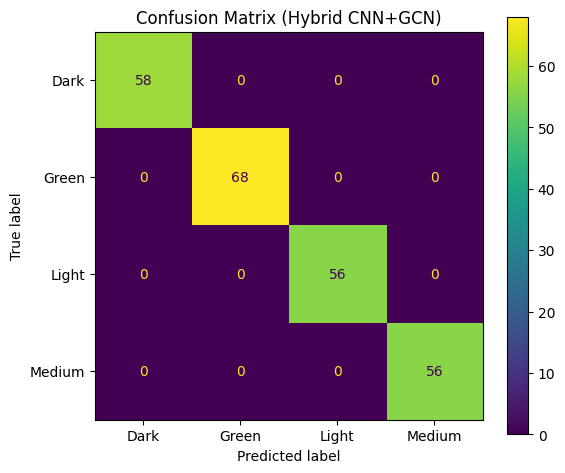

,Class,Precision,Recall,F1,Support
0,Dark,1.0,1.0,1.0,58
1,Green,1.0,1.0,1.0,68
2,Light,1.0,1.0,1.0,56
3,Medium,1.0,1.0,1.0,56


In [13]:
# 8) Test eval
hybrid.eval(); preds_all=[]; t_all=[]
with torch.no_grad():
    for X,y in test_loader:
        X=X.to(device); logits=hybrid(X); preds_all.append(logits.argmax(1).cpu().numpy()); t_all.append(y.numpy())
y_true=np.concatenate(t_all); y_pred=np.concatenate(preds_all); labels=list(range(len(class_names)))
P,R,F1,Sup=precision_recall_fscore_support(y_true,y_pred,labels=labels,average=None,zero_division=0)
wP,wR,wF1,_=precision_recall_fscore_support(y_true,y_pred,labels=labels,average='weighted',zero_division=0)
print(f"Weighted P/R/F1: {wP:.3f}/{wR:.3f}/{wF1:.3f}")
print(classification_report(y_true,y_pred,target_names=class_names,zero_division=0))
cm=confusion_matrix(y_true,y_pred,labels=labels)
fig,ax=plt.subplots(figsize=(6,5)); disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, values_format='d'); ax.set_title('Confusion Matrix (Hybrid CNN+GCN)'); plt.tight_layout(); plt.show()
import pandas as pd
pd.DataFrame({"Class":class_names,"Precision":P,"Recall":R,"F1":F1,"Support":Sup})

In [19]:
from PIL import Image

# Pakai normalisasi yang sama seperti eval_tf
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
IMG_SIZE = 224  # harus konsisten dengan training

inference_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

def load_hybrid_from_checkpoint(ckpt_path, class_names=None, device=None,
                                gcn_hidden=256, gcn_dropout=0.1, grid_radius=1):
    """
    Muat model Hybrid dari checkpoint .pth.
    - Abaikan key 'A_hat' (adjacency) karena akan dibuat ulang di forward.
    - Juga abaikan key yang shape-nya tidak cocok (mis. jika num_classes berubah).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ckpt = torch.load(ckpt_path, map_location=device)

    # Ambil nama kelas dari ckpt jika tidak diberikan
    if class_names is None:
        class_names = ckpt.get("classes", None)
        if class_names is None:
            raise ValueError("class_names tidak tersedia di ckpt; berikan argumen class_names secara manual.")

    # Bangun model kosong dengan arsitektur yang sama
    model = CNN_GNN_Hybrid(
        num_classes=len(class_names),
        gcn_hidden=gcn_hidden,
        gcn_dropout=gcn_dropout,
        radius=grid_radius
    ).to(device)
    model.eval()

    # Siapkan state_dict yang kompatibel:
    # - drop 'A_hat'
    # - hanya keep key yang ada di model dan shape-nya sama
    src = ckpt["state_dict"]
    src = {k: v for k, v in src.items() if k != "A_hat"}  # buang adjacency tersimpan

    dst = model.state_dict()
    filtered = {k: v for k, v in src.items() if (k in dst and dst[k].shape == v.shape)}

    missing = [k for k in dst.keys() if k not in filtered]
    unexpected = [k for k in src.keys() if k not in filtered]

    # Update dan load
    dst.update(filtered)
    model.load_state_dict(dst, strict=False)

    if unexpected:
        print("[load_hybrid_from_checkpoint] Ignored (unexpected):", unexpected)
    if missing:
        # biasanya aman (mis. 'A_hat' akan dibuat otomatis), ini hanya info
        print("[load_hybrid_from_checkpoint] Missing (left as init):", [k for k in missing if "A_hat" in k or "num_batches_tracked" not in k])

    return model, class_names

def preprocess_image(path_or_pil, tf=inference_tf):
    """
    Baca gambar dari path atau PIL.Image, kembalikan tensor (1,3,H,W).
    """
    if isinstance(path_or_pil, (str, os.PathLike)):
        img = Image.open(path_or_pil).convert("RGB")
    else:
        img = path_or_pil.convert("RGB")
    x = tf(img).unsqueeze(0)
    return img, x

@torch.no_grad()
def predict_image(model, img_tensor, device=None, topk=3):
    """
    Prediksi single image tensor (1,3,H,W).
    Return: (topk_labels, topk_probs_tensor, probs_numpy)
    """
    if device is None:
        device = next(model.parameters()).device
    img_tensor = img_tensor.to(device)

    # Autocast untuk GPU (aman karena A_hat dicast di layer GCN)
    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)[0]  # (C,)

    k = min(topk, probs.numel())
    vals, idxs = torch.topk(probs, k=k)
    return idxs, vals, probs

def show_prediction(img_pil, class_names, idxs, vals):
    """
    Tampilkan gambar + Top-k prediksi (teks & bar chart sederhana).
    """
    # Tampilkan gambar
    plt.figure(figsize=(5,5))
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title("Input Image")
    plt.tight_layout()
    plt.show()

    # Tampilkan top-k sebagai bar chart
    labels = [class_names[i] for i in idxs.cpu().numpy()]
    scores = vals.cpu().numpy()

    plt.figure(figsize=(6, 3 + 0.4*len(labels)))
    y = np.arange(len(labels))
    plt.barh(y, scores)  # jangan set warna/style khusus
    plt.yticks(y, labels)
    plt.xlabel("Probability")
    plt.xlim(0, 1)
    plt.title("Top Predictions")
    # Tampilkan nilai di ujung bar
    for yi, sc in zip(y, scores):
        plt.text(sc + 0.01, yi, f"{sc:.3f}", va="center")
    plt.tight_layout()
    plt.show()

def predict_image_from_path(ckpt_path, image_path, class_names=None, device=None,
                            gcn_hidden=256, gcn_dropout=0.1, grid_radius=1, topk=3):
    """
    Fungsi satu pintu: load model -> preprocess -> predict -> tampilkan.
    """
    model, classes = load_hybrid_from_checkpoint(
        ckpt_path, class_names=class_names, device=device,
        gcn_hidden=gcn_hidden, gcn_dropout=gcn_dropout, grid_radius=grid_radius
    )
    img_pil, x = preprocess_image(image_path, tf=inference_tf)
    idxs, vals, probs = predict_image(model, x, device=device, topk=topk)

    # Print ringkas di console
    print("Top-{} predictions:".format(topk))
    for rank, (i, v) in enumerate(zip(idxs.tolist(), vals.tolist()), start=1):
        print(f"{rank}. {classes[i]} — prob={v:.4f}")

    # Visual
    show_prediction(img_pil, classes, idxs, vals)

    return {"topk_indices": idxs, "topk_probs": vals, "all_probs": probs.cpu().numpy(), "classes": classes}

Top-3 predictions:
1. Medium — prob=0.9874
2. Light — prob=0.0126
3. Dark — prob=0.0000


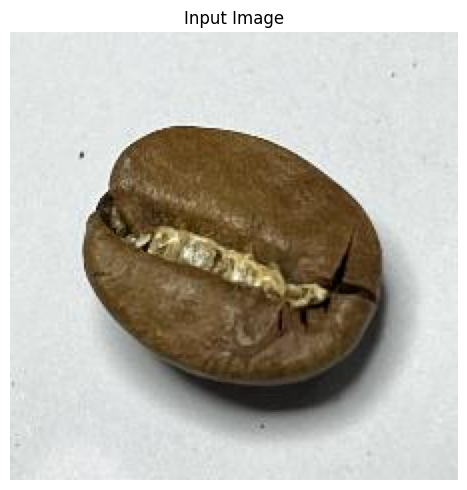

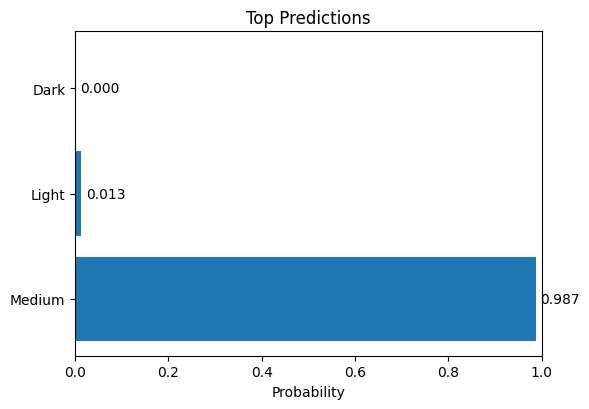

In [20]:
# Path ke checkpoint & gambar uji
ckpt_path = "cnn_gnn_hybrid_best.pth"
test_image_path = "dataset/test/Medium/medium-21-_png.rf.48a5175ff50de48471771a5022adba82.jpg"

# class_names bisa diambil dari ckpt; kalau mau override, berikan list sendiri
out = predict_image_from_path(
    ckpt_path=ckpt_path,
    image_path=test_image_path,
    class_names=None,     # atau pakai class_names dari dataset jika ingin paksa urutan tertentu
    device=None,          # otomatis pakai device dari model
    gcn_hidden=GCN_HIDDEN,
    gcn_dropout=GCN_DROPOUT,
    grid_radius=GRID_RADIUS,
    topk=3
)

## (Opsional) Unfreeze sebagian backbone
Gunakan ini setelah training utama untuk fine-tuning halus (LR kecil).


In [ ]:
def unfreeze_backbone(hybrid_model, target_prefixes=("layer3",)):
    cnt=0
    for name,p in hybrid_model.backbone.stem.named_parameters():
        if any(pref in name for pref in target_prefixes): p.requires_grad=True; cnt+=p.numel()
    print('Unfroze params:', cnt)
# Contoh pakai:
# unfreeze_backbone(hybrid)
# optimizer = torch.optim.AdamW([p for p in hybrid.parameters() if p.requires_grad], lr=5e-5, weight_decay=1e-4)
# lalu jalankan beberapa epoch training tambahan.